# Single-Cell Expression Analysis Demo - 82K Cells

* Dataset: [GSE134809](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE134809)
* Paper: Martin et al. ["Single-Cell Analysis of Crohn’s Disease Lesions Identifies a Pathogenic Cellular Module Associated with Resistance to Anti-TNF Therapy"](https://www.sciencedirect.com/science/article/pii/S0092867419308967), 2019.
* Size: 82,417 lamina propria cells from 22 paired inflamed and uninflamed ileum tissues of 11 iCD patients

### Set instance and token

In [2]:
library(integrationCurator)
suppressMessages(library(tidyverse))

Sys.setenv(PRED_SPOT_HOST='odm-demos.genestack.com',
           PRED_SPOT_TOKEN='<token>',
           PRED_SPOT_VERSION='default-released')
page_limit = 2000

### Query tissue metadata (for inflamed ileum tissues from GIMATS+/GIMATS- patients)

In [3]:
study_filter = sprintf('"%s"="%s"', 'genestack:accession', 'GSF819695')

tissue_filter = sprintf('"%s"="%s"', 'status.ch1', 'Involved')
patient_filter_pos = sprintf('"%s"="%s"', 'Patient Status', 'GIMATS+')
patient_filter_neg = sprintf('"%s"="%s"', 'Patient Status', 'GIMATS-')
sample_filter = sprintf('%s AND (%s OR %s)', tissue_filter, patient_filter_pos, patient_filter_neg)

start = Sys.time()
samples <- as_tibble(integrationCurator::OmicsQueriesApi_search_samples(
    study_filter=study_filter,
    sample_filter=sample_filter,
    page_limit=page_limit
)$content$data[['metadata']])
samples = samples[, c('genestack:accession','Sample Source ID','Patient ID','Patient Status','status.ch1')]

cat(sprintf('Time to get %s samples: %s seconds\n\n', nrow(samples), round(Sys.time()-start)))
print(samples)

Time to get 9 samples: 1 seconds

# A tibble: 9 x 5
  `genestack:accessi… `Sample Source I… `Patient ID` `Patient Status` status.ch1
  <chr>               <chr>             <chr>        <chr>            <chr>     
1 GSF819708           181               11           GIMATS+          Involved  
2 GSF819710           187               12           GIMATS+          Involved  
3 GSF819712           190               13           GIMATS-          Involved  
4 GSF819698           69                5            GIMATS+          Involved  
5 GSF819714           193               14           GIMATS-          Involved  
6 GSF819716           196               15           GIMATS-          Involved  
7 GSF819701           128               7            GIMATS+          Involved  
8 GSF819704           138               8            GIMATS+          Involved  
9 GSF819705           158               10           GIMATS-          Involved  


### Query expression values (for gene TNF)

In [14]:
gene = 'TNF'
expression_filter = sprintf('Gene=%s MinValue=0', gene)

start = Sys.time()
expressions = as_tibble(do.call(cbind, OmicsQueriesApi_search_expression_data(
    study_filter = study_filter,
    sample_filter = sample_filter,
    ex_query = expression_filter,
    page_limit = page_limit
)$content$data))

cat(sprintf('Time to get %s expression values: %s seconds\n\n', 
    nrow(expressions), round(Sys.time()-start)))
print(expressions)

Time to get 573 expression values: 2 seconds

# A tibble: 573 x 13
   itemId `metadata.Exper… metadata.Source `metadata.Data … `metadata.Genom…
   <fct>  <chr>            <chr>           <chr>            <chr>           
 1 GSF82… Illumina NextSe… RNA-Seq         Cell Ranger v2.0 GRCh38          
 2 GSF82… Illumina NextSe… RNA-Seq         Cell Ranger v2.0 GRCh38          
 3 GSF82… Illumina NextSe… RNA-Seq         Cell Ranger v2.0 GRCh38          
 4 GSF82… Illumina NextSe… RNA-Seq         Cell Ranger v2.0 GRCh38          
 5 GSF82… Illumina NextSe… RNA-Seq         Cell Ranger v2.0 GRCh38          
 6 GSF82… Illumina NextSe… RNA-Seq         Cell Ranger v2.0 GRCh38          
 7 GSF82… Illumina NextSe… RNA-Seq         Cell Ranger v2.0 GRCh38          
 8 GSF82… Illumina NextSe… RNA-Seq         Cell Ranger v2.0 GRCh38          
 9 GSF82… Illumina NextSe… RNA-Seq         Cell Ranger v2.0 GRCh38          
10 GSF82… Illumina NextSe… RNA-Seq         Cell Ranger v2.0 GRCh38          
# … with 

### Get external cell-level metadata

In [15]:
cell_metadata = read_tsv('https://bio-test-data.s3.amazonaws.com/GSE134809/cell_metadata_GSE134809.tsv',
                         col_types = cols(.default = "c"))
cell_metadata = cell_metadata %>% unite('cell', Lane:Barcode, sep='/')

expressions = inner_join(expressions, cell_metadata, by=c('metadata.Run Source ID'='cell'))
expressions = inner_join(expressions, samples, by=c('relationships.sample'='genestack:accession'))
print(expressions)

# A tibble: 573 x 20
   itemId `metadata.Exper… metadata.Source `metadata.Data … `metadata.Genom…
   <fct>  <chr>            <chr>           <chr>            <chr>           
 1 GSF82… Illumina NextSe… RNA-Seq         Cell Ranger v2.0 GRCh38          
 2 GSF82… Illumina NextSe… RNA-Seq         Cell Ranger v2.0 GRCh38          
 3 GSF82… Illumina NextSe… RNA-Seq         Cell Ranger v2.0 GRCh38          
 4 GSF82… Illumina NextSe… RNA-Seq         Cell Ranger v2.0 GRCh38          
 5 GSF82… Illumina NextSe… RNA-Seq         Cell Ranger v2.0 GRCh38          
 6 GSF82… Illumina NextSe… RNA-Seq         Cell Ranger v2.0 GRCh38          
 7 GSF82… Illumina NextSe… RNA-Seq         Cell Ranger v2.0 GRCh38          
 8 GSF82… Illumina NextSe… RNA-Seq         Cell Ranger v2.0 GRCh38          
 9 GSF82… Illumina NextSe… RNA-Seq         Cell Ranger v2.0 GRCh38          
10 GSF82… Illumina NextSe… RNA-Seq         Cell Ranger v2.0 GRCh38          
# … with 563 more rows, and 15 more variables: metadata

### Compare TNF expression across cell types, between GIMATS+ vs GIMATS- patients
It is interesting that TNF was produced mainly by T cells in patients with low GIMATS module scores, while it was produced both by T cells and infl. MNPs in patients with a high module scores.

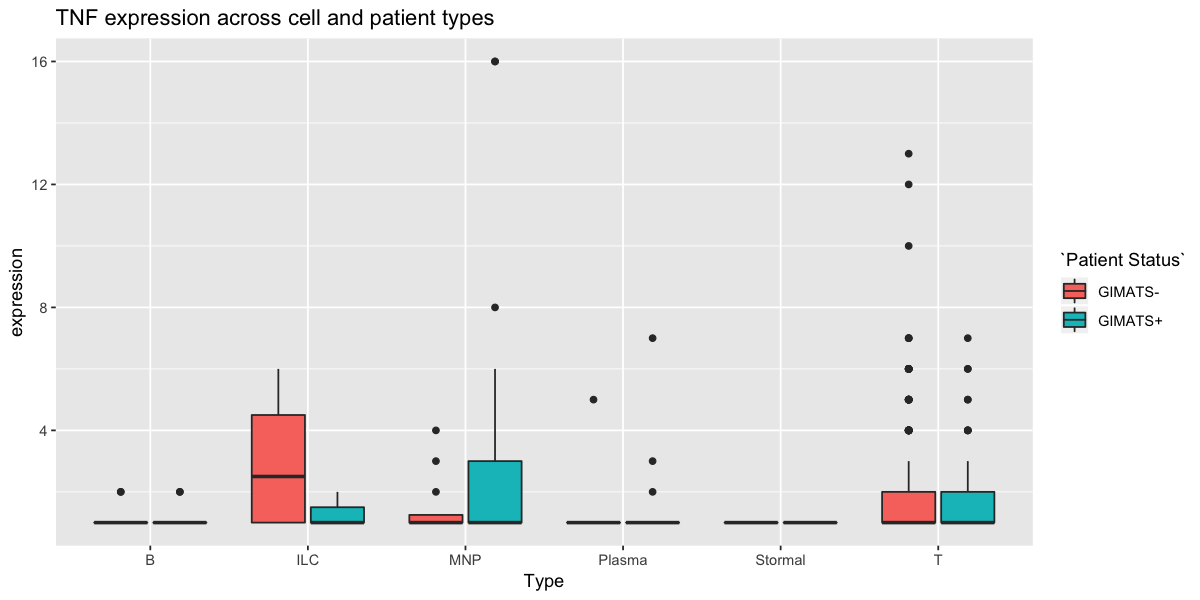

In [16]:
library(repr)
options(repr.plot.width=10, repr.plot.height=5)
ggplot(expressions, 
    mapping=aes(x=`Type`, y=expression, fill=`Patient Status`)) + 
    geom_boxplot() + ggtitle(sprintf('%s expression across cell and patient types', gene))